# idinvert: GAN inversion

## [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ml4a/ml4a-guides/blob/ml4a.net/examples/models/idinvert.ipynb)

Invert (encode) real images into the latent space of a pre-trained domain-specific [StyleGAN2](https://github.com/NVLabs/stylegan2/), so as to perform generative modeling operations on it, including fusing it into a separate image in the same domain, interpolating between real images, and editing salient features, such as (in the case of faces) age, gender, pose, and expression. See the [original code](https://github.com/genforce/idinvert_pytorch) and [paper](https://arxiv.org/pdf/2004.00049.pdf).

## Set up ml4a

If you don't already have ml4a and its dependencies installed, or you are opening this in Colab, first run the following cell.

In [ ]:
%tensorflow_version 1.x
!pip3 install --quiet git+https://github.com/ml4a/ml4a-guides.git@ml4a.net#egg=ml4a

## Check available models

`idinvert.get_available_models` will print the pre-trained models (encoder and generator) which are available.

In [1]:
from ml4a.models import idinvert
idinvert.get_available_models()

dict_keys(['bedroom', 'ffhq', 'tower'])

## Invert an image

We will invert an image into StyleGAN2's "ffhq" pre-trained model (faces). We first load an image of a face from the web, and extract a center crop of it using the `ml4a.utils.face` utility.

Display target face


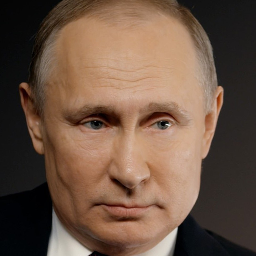

In [2]:
from ml4a import image
from ml4a.utils import face

img = image.load_image('https://upload.wikimedia.org/wikipedia/commons/thumb/8/8d/Vladimir_Putin_%282020-02-20%29.jpg/1200px-Vladimir_Putin_%282020-02-20%29.jpg')
target_image, face_found = face.align_face(img, face_width=idinvert.resolution)  # match idinvert's resolution
image.display(target_image, title="Display target face")


After inverting the above image, we are going to "fuse" it onto some other "context" faces. We first load those context faces.

context faces


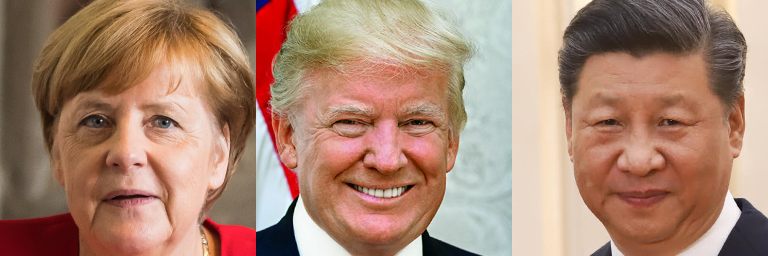

In [3]:
context_paths = [
    'https://upload.wikimedia.org/wikipedia/commons/a/a8/Angela_Merkel_2019_%28cropped%29.jpg',
    'https://bookstore.gpo.gov/sites/default/files/styles/product_page_image/public/covers/potus2_0.jpg',
    'https://upload.wikimedia.org/wikipedia/commons/3/32/Xi_Jinping_2019.jpg'    
]

context_images = []
for path in context_paths:
    img = image.load_image(path)
    aligned_face, face_found = face.align_face(img, face_width=idinvert.resolution)
    if face_found:
        context_images.append(aligned_face)

image.display(context_images, title="context faces")

`idinvert.fuse` will fuse the target face onto the context faces. You must specify `center_x`, `center_y`, and `crop_size`; these determine the coordinates of the bounding box onto which we will superimpose the target images. The bounding box will be a `crop_size * crop_size` square centered at (`center_x`, `center_y`).

[2020-12-01 22:59:56,451][INFO] Build network for module `generator` in model `styleganinv_ffhq256`.
[2020-12-01 22:59:56,591][INFO] Loading pytorch weights from `/home/bzion/.ml4a/idinvert_pytorch/styleganinv_ffhq256_generator.pth`.
[2020-12-01 22:59:56,706][INFO] Successfully loaded!
[2020-12-01 22:59:58,412][INFO] Current `lod` is 0.0.
[2020-12-01 22:59:58,413][INFO] Build network for module `encoder` in model `styleganinv_ffhq256`.
[2020-12-01 22:59:59,217][INFO] Loading pytorch weights from `/home/bzion/.ml4a/idinvert_pytorch/styleganinv_ffhq256_encoder.pth`.
[2020-12-01 23:00:00,146][INFO] Successfully loaded!


loss_pix: 0.005, loss_feat: 290.346, loss: 0.019: 100%|██████████| 100/100 [00:13<00:00,  7.21it/s]

superimposed images


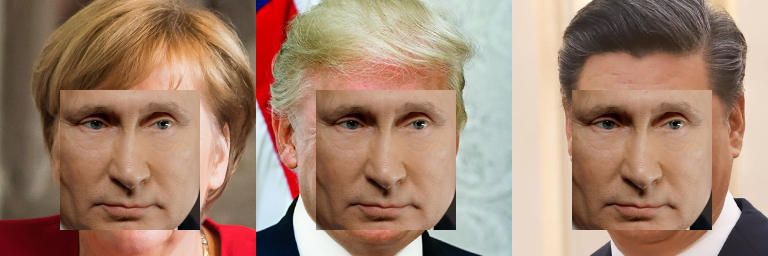

diffused images


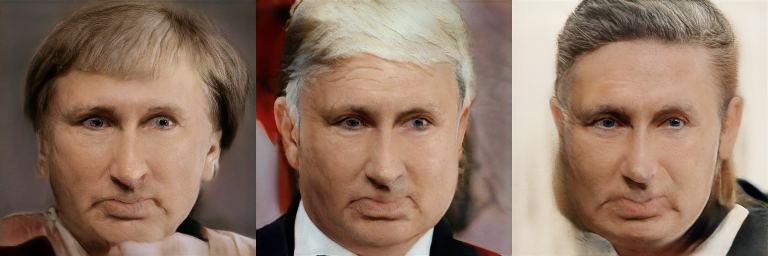

In [4]:
showed_fuses, diffused_images = idinvert.fuse('ffhq', 
                                              context_images, target_image, 
                                              crop_size=140, center_x=130, center_y=160)
image.display(showed_fuses, title="superimposed images")
image.display(diffused_images, title="diffused images")

## In-domain editing

Another application of idinvert is to manipulate the features of a real image. We first project a real image (the same face sample as above) into the latent space of a pre-trained 256x256 StyleGAN2 trained on the ffqh dataset (faces). 

The function `idinvert.invert` runs an optimization to find a latent code which generates a face that looks as close to the original as possible.

In [5]:
latent_code = idinvert.invert('ffhq', target_image, redo=False, save=False)

loss_pix: 0.033, loss_feat: 3216.035, loss_reg: 0.038, loss: 0.269:   0%|          | 0/100 [00:00<?, ?it/s]

optimizing latent_code to reconstruct target image...


loss_pix: 0.011, loss_feat: 1194.378, loss_reg: 0.009, loss: 0.089: 100%|██████████| 100/100 [00:08<00:00, 11.98it/s]


We then generate an image from the generator, using the latent code from the previous step. We can compare the "reconstructed" image to the original.

[2020-12-01 23:00:22,828][INFO] Build network for module `generator` in model `styleganinv_ffhq256`.
[2020-12-01 23:00:22,974][INFO] Loading pytorch weights from `/home/bzion/.ml4a/idinvert_pytorch/styleganinv_ffhq256_generator.pth`.
[2020-12-01 23:00:23,080][INFO] Successfully loaded!
[2020-12-01 23:00:23,111][INFO] Current `lod` is 0.0.
original and reconstruction


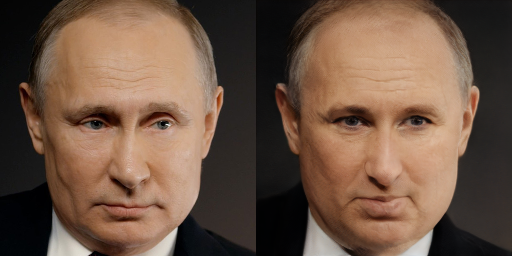

In [6]:
reconstruction = idinvert.generate('ffhq', latent_code)
image.display([target_image, reconstruction[0]], title="original and reconstruction")

## Applying transformations

Each of the pre-trained models in `idinvert` comes with several attribute vectors which correspond to salient directions in the latent space of the GAN. By moving some distance along these directions from the latent vector found in the previous step (`latent_code`), we can apply these feature transformations to the reconstructed image.

In the case of the ffhq model, the directions are for age, eyeglasses, gender, head pose, and expression/smile. 

For example, the function `idinvert.modulate(latent_code, 'age', X)` will multiply the aging vector by `X` and add it to the latent code `latent_code`. If `X` is positive, the resulting image should look older; if `X` is negative, then younger.

We demonstrate some examples in the next cell. First, we get a list of the available attribute vectors.

In [7]:
idinvert.get_attributes()

dict_keys(['age', 'expression', 'eyeglasses', 'gender', 'pose'])

For ffhq, we have the following attributes available: 'age', 'expression', 'eyeglasses', 'gender', and 'pose'.

In the next cell, we'll add and subtract a bit of each attribute vector to the latent code, and look at each group of three (minus the attribute, unchanged, plus the attribute) side-by-side.

Note that the `generate` function takes a list of latent codes so it can generate batches. We are using batch sizes of 1, but we still need to take the 0th element from the resulting list of each `generate` call.

young to old


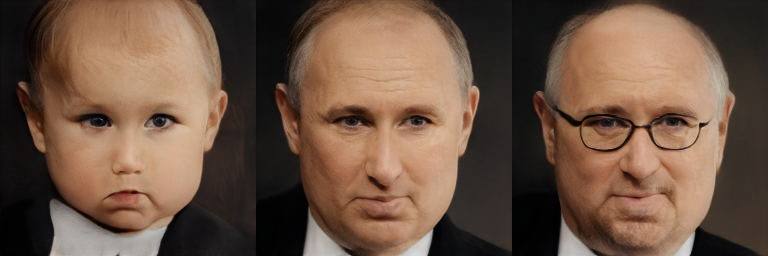

no eyeglasses to eyeglasses


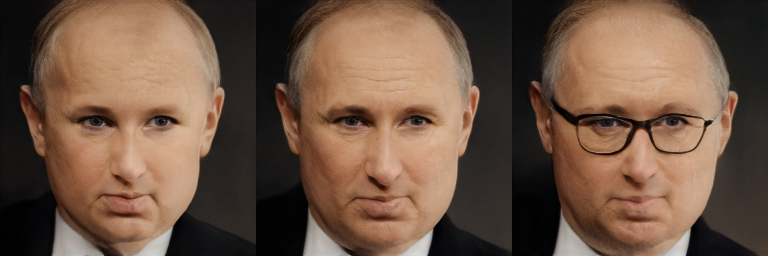

female to male


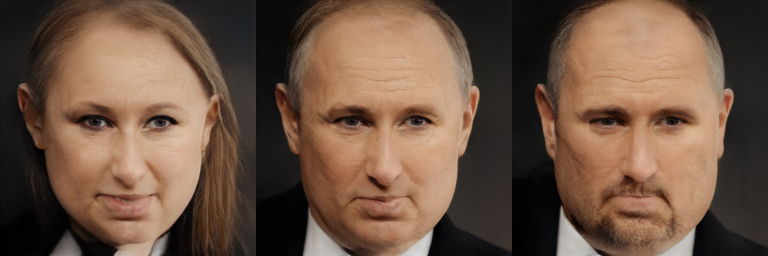

turning right to turning left


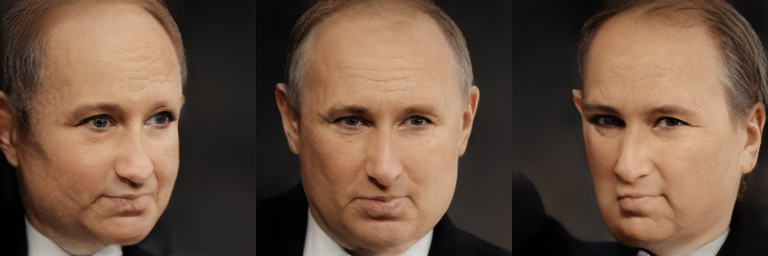

not smiling to smiling


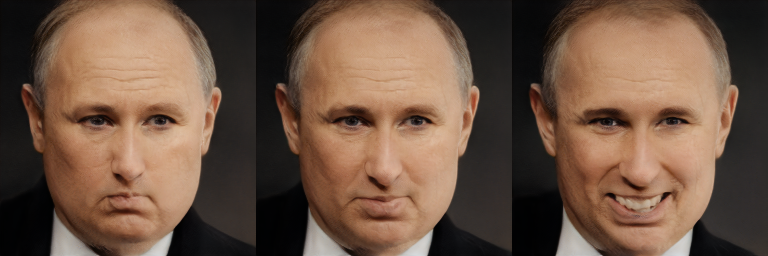

In [8]:
image.display([
    idinvert.generate('ffhq', idinvert.modulate(latent_code, 'age', -2.0))[0],
    reconstruction[0],
    idinvert.generate('ffhq', idinvert.modulate(latent_code, 'age', +2.0))[0]],
    title="young to old")

image.display([
    idinvert.generate('ffhq', idinvert.modulate(latent_code, 'eyeglasses', -2.0))[0],
    reconstruction[0],
    idinvert.generate('ffhq', idinvert.modulate(latent_code, 'eyeglasses', +2.0))[0]],
    title="no eyeglasses to eyeglasses")

image.display([
    idinvert.generate('ffhq', idinvert.modulate(latent_code, 'gender', -2.0))[0],
    reconstruction[0],
    idinvert.generate('ffhq', idinvert.modulate(latent_code, 'gender', +2.0))[0]],
    title="female to male")

image.display([
    idinvert.generate('ffhq', idinvert.modulate(latent_code, 'pose', -2.0))[0],
    reconstruction[0],
    idinvert.generate('ffhq', idinvert.modulate(latent_code, 'pose', +2.0))[0]],
    title="turning right to turning left")

image.display([
    idinvert.generate('ffhq', idinvert.modulate(latent_code, 'expression', -2.0))[0],
    reconstruction[0],
    idinvert.generate('ffhq', idinvert.modulate(latent_code, 'expression', +2.0))[0]],
    title="not smiling to smiling")


Since the transition is continuous, we can animate it. Below we interpolate between the two extremes of age.

In [9]:
import numpy as np

frames = [idinvert.generate('ffhq', idinvert.modulate(latent_code, 'age', r))[0] 
          for r in np.linspace(-2.0, +2.0, 60)]
image.display(frames, animate=True, title="Age range")

Same thing, but for expression (smile).

In [10]:
frames = [idinvert.generate('ffhq', idinvert.modulate(latent_code, 'expression', r))[0] 
          for r in np.linspace(-3.0, +3.0, 60)]
image.display(frames, animate=True, title="Expression range")

## Towers model

`idinvert` has two more pre-trained models, "tower" and "bedroom." We'll load the tower model and reconstruct an image of the Eiffel Tower.

[2020-12-01 23:00:26,141][INFO] Build network for module `generator` in model `styleganinv_tower256`.
[2020-12-01 23:00:26,292][INFO] Loading pytorch weights from `/home/bzion/.ml4a/idinvert_pytorch/styleganinv_tower256_generator.pth`.
[2020-12-01 23:00:26,403][INFO] Successfully loaded!
[2020-12-01 23:00:26,435][INFO] Current `lod` is 0.0.
[2020-12-01 23:00:26,435][INFO] Build network for module `encoder` in model `styleganinv_tower256`.
[2020-12-01 23:00:27,237][INFO] Loading pytorch weights from `/home/bzion/.ml4a/idinvert_pytorch/styleganinv_tower256_encoder.pth`.
[2020-12-01 23:00:28,150][INFO] Successfully loaded!


loss_pix: 0.072, loss_feat: 2801.513, loss_reg: 0.015, loss: 0.242:   2%|▏         | 2/100 [00:00<00:06, 14.16it/s]

optimizing latent_code to reconstruct target image...


loss_pix: 0.031, loss_feat: 1228.061, loss_reg: 0.006, loss: 0.104: 100%|██████████| 100/100 [00:08<00:00, 11.77it/s]

[2020-12-01 23:00:36,933][INFO] Build network for module `generator` in model `styleganinv_tower256`.


[2020-12-01 23:00:37,081][INFO] Loading pytorch weights from `/home/bzion/.ml4a/idinvert_pytorch/styleganinv_tower256_generator.pth`.
[2020-12-01 23:00:37,190][INFO] Successfully loaded!
[2020-12-01 23:00:37,221][INFO] Current `lod` is 0.0.
original and reconstruction


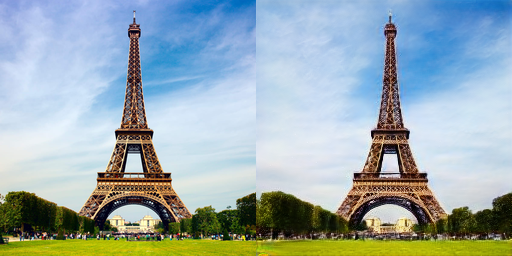

In [11]:
target_image1 = image.load_image('https://www.history.com/.image/ar_1:1%2Cc_fill%2Ccs_srgb%2Cfl_progressive%2Cq_auto:good%2Cw_1200/MTU3ODc4NjAzNTM2MTQ4MTkx/hith-eiffel-tower-istock_000016468972large-2.jpg',
                                (256, 256), 
                                autocrop=True)

latent_code1 = idinvert.invert('tower', target_image1)
reconstruction1 = idinvert.generate('tower', latent_code1)

image.display([target_image1, reconstruction1[0]], title="original and reconstruction")

Same thing, but for the statue of liberty.

optimizing latent_code to reconstruct target image...


loss_pix: 0.042, loss_feat: 1880.715, loss_reg: 0.010, loss: 0.156: 100%|██████████| 100/100 [00:08<00:00, 11.68it/s]


original and reconstruction


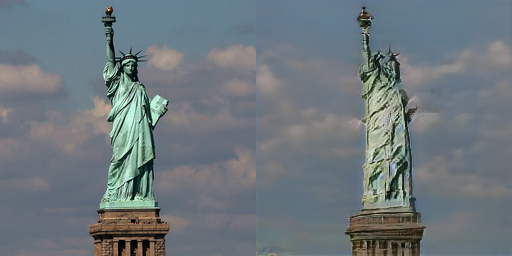

In [12]:
target_image2 = image.load_image('https://imageproxy.themaven.net//https%3A%2F%2Fwww.history.com%2F.image%2FMTU3ODc3NjU2MjA0NDIwNDI1%2Fthis-day-in-history-06171885---statue-of-liberty-arrives.jpg', 
                                (256, 256), 
                                autocrop=True)

latent_code2 = idinvert.invert('tower', target_image2)
reconstruction2 = idinvert.generate('tower', latent_code2)

image.display([target_image2, reconstruction2[0]], title="original and reconstruction")

Another trick is to interpolate between the latent codes. Below is an interpolation between the latent codes for the Eiffel Tower and Statue of Liberty.

In [13]:
frames = [idinvert.generate('tower', (1.0-r)*latent_code1 + r*latent_code2)[0] 
          for r in np.linspace(0, 1.0, 60)]
image.display(frames, animate=True, title="statues")

We'll repeat our experiment adding and subtracting each of the available attribute vectors to the latent code of the Eiffel Tower. First we list them again to see what they are.

In [15]:
idinvert.get_attributes()

dict_keys(['clouds', 'sunny', 'vegetation'])

Finally, we'll display each transformation compared to the original.

less cloudy to more cloudy


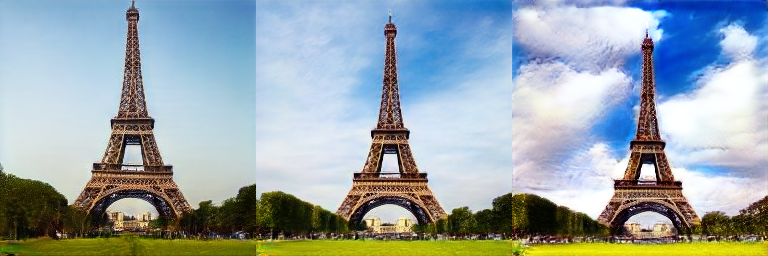

less sunny to more sunny


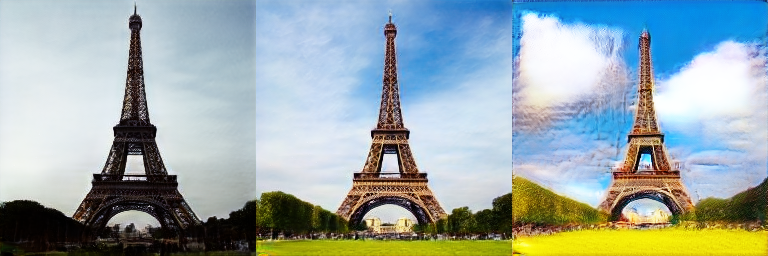

less vegetation to more vegetation


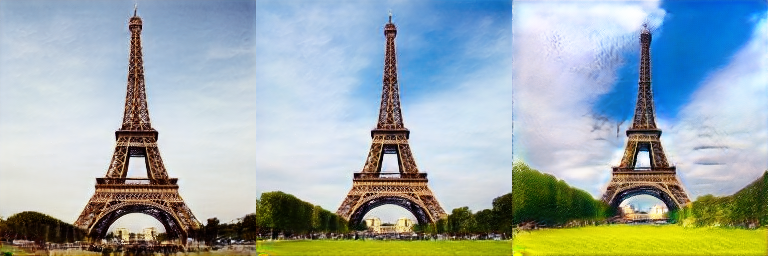

In [21]:
image.display([
    idinvert.generate('tower', idinvert.modulate(latent_code1, 'clouds', -3.0))[0],
    reconstruction1[0],
    idinvert.generate('tower', idinvert.modulate(latent_code1, 'clouds', +3.0))[0]],
    title="less cloudy to more cloudy")

image.display([
    idinvert.generate('tower', idinvert.modulate(latent_code1, 'sunny', -3.0))[0],
    reconstruction1[0],
    idinvert.generate('tower', idinvert.modulate(latent_code1, 'sunny', +3.0))[0]],
    title="less sunny to more sunny")

image.display([
    idinvert.generate('tower', idinvert.modulate(latent_code1, 'vegetation', -3.0))[0],
    reconstruction1[0],
    idinvert.generate('tower', idinvert.modulate(latent_code1, 'vegetation', +3.0))[0]],
    title="less vegetation to more vegetation")
